# Implementação com Threads OpenMP

## Geração do grafo

In [1]:
%%writefile gera_grafo.py
import networkx as nx
import random

# Parâmetros
num_vertices = 136  # Número de vértices no grafo
probabilidade_conexao = 0.7  # Probabilidade de haver uma aresta entre dois vértices (ajuste conforme necessário)

# Crie um grafo aleatório densamente conectado
grafo = nx.fast_gnp_random_graph(num_vertices, probabilidade_conexao)

# Nome do arquivo de saída
nome_arquivo = "grafo.txt"

# Abra o arquivo para escrita
with open(nome_arquivo, 'w') as arquivo:
    # Escreva a quantidade de vértices e número de arestas na primeira linha
    arquivo.write(f"{num_vertices} {grafo.number_of_edges()}\n")

    # Escreva as arestas no formato de lista de adjacência
    for aresta in grafo.edges():
        arquivo.write(f"{aresta[0]+1} {aresta[1]+1}\n")  # +1 para ajustar os índices (começando em 1)

print(f"Grafo densamente conectado gerado e salvo em '{nome_arquivo}'.")

# Image of the generated graph
import matplotlib.pyplot as plt

# Alterar edges do grafo para edge + 1
novas_arestas = [(u + 1, v + 1) for u, v in grafo.edges()]
novo_grafo = nx.Graph()
novo_grafo.add_edges_from(novas_arestas)
novo_grafo.add_nodes_from([n + 1 for n in grafo.nodes()])

# Desenhar o grafo
nx.draw(novo_grafo, with_labels=True)
plt.show()

Writing gera_grafo.py


Grafo densamente conectado gerado e salvo em 'grafo.txt'.


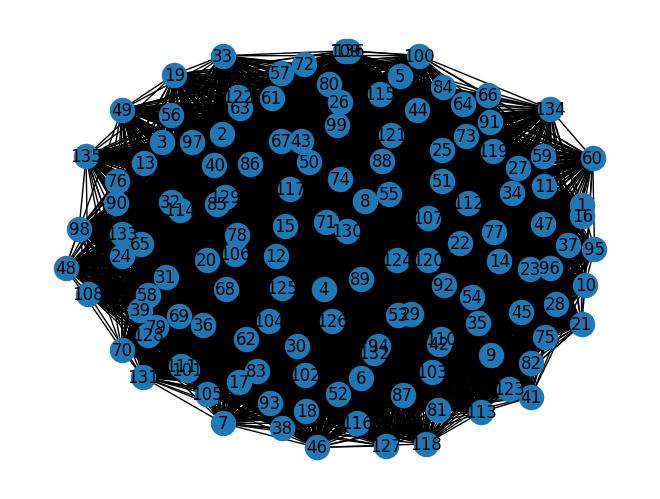

In [2]:
%run gera_grafo.py

## Código-fonte modificado - OpenMP

In [3]:
%%writefile threads_openmp.cpp
#include <iostream>
#include <vector>
#include <fstream>
#include <algorithm>
#include <functional>
#include <omp.h>
#include <mutex>

using namespace std;

vector<vector<int> > LerGrafo(const string& nomeArquivo, int& numVertices) {
    ifstream arquivo(nomeArquivo);
    int numArestas;
    arquivo >> numVertices >> numArestas;
    vector<vector<int> > grafo(numVertices, vector<int>(numVertices, 0));
    for (int i = 0; i < numArestas; ++i) {
        int u, v;
        arquivo >> u >> v;
        grafo[u - 1][v - 1] = 1;
        grafo[v - 1][u - 1] = 1;
    }
    arquivo.close();
    return grafo;
}

bool VerificaClique(const vector<vector<int> >& grafo, const vector<int>& clique) {
    for (int i = 0; i < clique.size(); i++) {
        for (int j = i + 1; j < clique.size(); j++) {
            if (grafo[clique[i]][clique[j]] == 0) { return false; }
        }
    }
    return true;
}

void EncontrarCliqueMaxima(const vector<vector<int> >& grafo, int numVertices, vector<int>& cliqueMaxima) {
    vector<int> cliqueGlobal;
    mutex mtx;  // Protege o acesso ao clique máximo global

    #pragma omp parallel
    {
        vector<int> cliqueLocal;  // Clique máximo de cada thread
        vector<int> atualClique;

        // Função recursiva para construir cliques
        auto backtrack = [&](int v, auto& backtrack_ref) -> void {
            if (atualClique.size() > cliqueLocal.size()) { cliqueLocal = atualClique; }

            for (int i = v; i < numVertices; i++) {
                atualClique.push_back(i);
                if (VerificaClique(grafo, atualClique)) { backtrack_ref(i + 1, backtrack_ref); }
                atualClique.pop_back();
            }
        };

        #pragma omp for schedule(dynamic)
        for (int i = 0; i < numVertices; i++) {
            atualClique.clear();
            atualClique.push_back(i);
            backtrack(i + 1, backtrack);
        }

        // Atualiza o clique máximo global
        mtx.lock();
        if (cliqueLocal.size() > cliqueGlobal.size()) { cliqueGlobal = cliqueLocal; }
        mtx.unlock();
    }
    cliqueMaxima = cliqueGlobal;
}

int main() {
    int numVertices = 136;
    vector<vector<int> > grafo = LerGrafo("grafo.txt", numVertices);
    vector<int> cliqueMaxima;
    double start = omp_get_wtime();
    EncontrarCliqueMaxima(grafo, numVertices, cliqueMaxima);
    double end = omp_get_wtime();

    cout << "Clique máxima arquivo saída: ";
    for (int i = 0; i < cliqueMaxima.size(); i++) { cout << cliqueMaxima[i] + 1 << " "; }
    cout << endl;

    cout << "Tempo de execução: " << (end - start) << " segundos" << endl;
    return 0;
}

Writing threads_openmp.cpp


In [4]:
!g++ -fopenmp threads_openmp.cpp -o threads_openmp

## Criando arquivos de configuração

In [5]:
%%writefile submit.slurm
#!/bin/bash
#SBATCH --job-name=openmp             # Nome do job
#SBATCH --output=openmp_%j.txt          # Nome do arquivo de saída
#SBATCH --ntasks=4                              # Número de tarefas 
#SBATCH --cpus-per-task=2                       # Número de threads por tarefa 
#SBATCH --mem=1024                               # Memória total alocada por nó
#SBATCH --time=00:20:00                         # Tempo máximo de execução
#SBATCH --partition=espec                      # fila do cluster a ser utilizada

./threads_openmp

Writing submit.slurm


In [6]:
!sbatch submit.slurm

Submitted batch job 9880


## Realizando a verificação de ambos os grafos

In [7]:
%%writefile verificacao_da_clique.py
import networkx as nx

# Abrir o arquivo e pular a primeira linha
with open("grafo.txt", 'r') as arquivo:
    next(arquivo)  # Pula a primeira linha

    # Lê o grafo a partir das linhas restantes
    G = nx.parse_adjlist(arquivo)

# Encontrar todas as cliques maximais
cliques_maximais = list(nx.find_cliques(G))

# Encontrar a clique máxima (a maior)
clique_maxima = max(cliques_maximais, key=len)

# Salvar as cliques maximais em um arquivo
with open("verificacao.txt", 'w') as arquivo:
    arquivo.write(f"Cliques maximais encontradas\n")
    for clique in cliques_maximais:
        arquivo.write(f"{' '.join(map(str, clique))}\n")
    arquivo.write(f"\nClique máxima encontrada\n")
    arquivo.write(f"{len(clique_maxima)} = {' '.join(map(str, clique_maxima))}\n")

Writing verificacao_da_clique.py


In [8]:
%run verificacao_da_clique.py

In [9]:
with open('verificacao.txt', 'r') as file:
    lines = file.readlines()  # Lê todas as linhas
    ultima_linha = lines[-1]  # Pega a última linha
    _, numeros = ultima_linha.split("=", 1)
    lista = list(map(int, numeros.split()))
    lista.sort()
print(lista)

with open('openmp_9880.txt', 'r') as file:
    lines = file.readlines()  # Lê todas as linhas
    print(lines)

[8, 13, 20, 43, 44, 50, 52, 61, 76, 84, 86, 89, 106, 121, 122, 130]
['Clique máxima arquivo saída: 8 13 20 30 43 44 50 52 61 84 86 89 106 121 122 130 \n', 'Tempo de execução: 77.3135 segundos\n']


## Justificativa das alterações

As alterações feitas no código para utilizar o OpenMP, com o objetivo de melhorar o desempenho da busca pelo clique máximo em um grafo, foram as seguintes:

- Inclusão de #include <omp.h> permiti o uso de recursos do OpenMP. 
- Região paralela criada com #pragma omp parallel, garantindo o trabalho de múltiplas threads ao mesmo tempo, cada um com sua variável cliqueLocal, diminuindo o risco de interferência entre threads.
- Loop principal foi paralelizado com #pragma omp for schedule(dynamic), possibilitando diferentes vértices do grafo serem processados por diferentes threads --> schedule(dynamic) escolhido pra lidar com possíveis desequilíbrios na carga de trabalho.
- Proteger o acesso à variável compartilhada com std::mutex, garantindo que apenas uma thread atualize o cliqueGlobal de cada vez, evitando condições de corrida.

## Speed up

É possível afirmar, baseando-se na Tabela a seguir, que houve um speed up impactante da implementação exaustiva para o openMP, com um tempo de execução aproximadamente 11 vezes mais rápido, e que com isso as mudanças foram extremamente beneficiais.

| Implementação | numVertices |   Tempo   |
|---------------|-------------|-----------|
| exaustiva     |     135     |  888.6 s  |
| openMP        |     136     | 77.3135 s |
